<a href="https://colab.research.google.com/github/unica-ml/ml/blob/master/notebooks/lab04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Lab04

## Preparation

We import here some utility functions from previous labs, and prepare loaders for the two-moon and MNIST digit data.

In [0]:
import numpy as np

from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import tensorflow as tf


def plot_dataset(x, y, feat0=0, feat1=1):
    colors = ['b.', 'r.', 'g.', 'k.', 'c.', 'm.']
    class_labels = np.unique(y).astype(int)
    for k in class_labels:
        plt.plot(x[y == k, feat0], x[y == k, feat1], colors[k % 7])


def plot_decision_regions(x, y, classifier, resolution=1e-3):
    # setup marker generator and color map
    colors = ('blue', 'red', 'lightgreen', 'black', 'cyan', 'magenta')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 0.02, x[:, 0].max() + 0.02
    x2_min, x2_max = x[:, 1].min() - 0.02, x[:, 1].max() + 0.02
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())


def load_mnist(n_samples, tr=False):
    if tr:
        # load mnist training (60,000 samples)
        (x, y), _ = tf.keras.datasets.mnist.load_data()  
    else:
        # load mnist test (10,000 samples)
        _, (x, y) = tf.keras.datasets.mnist.load_data() 
    # print(x.shape, y.shape)
    # let's reshape and subsample to the first 500 digits
    x = x.reshape(x.shape[0], 784)  # flatten each digit as a row
    x = x[:n_samples, :]  # take the first n_samples digits
    y = y[:n_samples]
    return x, y


def plot_digits(x, y, n=10):
    for i in range(n**2):
        plt.subplot(n,n,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='Greys')
        plt.axis('off')



Scatter two-moon data and MNIST digits

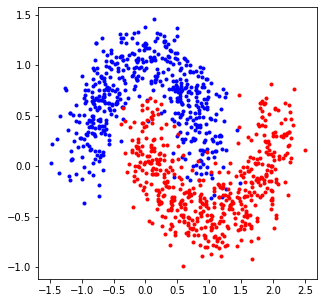

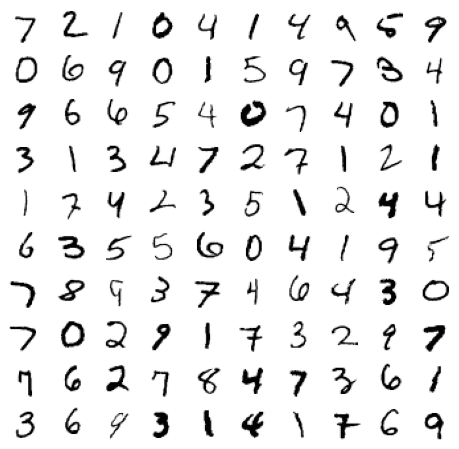

In [14]:
# sample data
x, y = make_moons(n_samples=1000, noise=0.2)
plt.figure(figsize=(5,5))
plot_dataset(x,y)
plt.show()

x, y = load_mnist(n_samples=1000)
plt.figure(figsize=(8,8))
plot_digits(x,y)
plt.show()

## Exercise 1 - Performance Evaluation

In [15]:
x, y = make_moons(n_samples=1000, noise=0.2)

splitter = ShuffleSplit(n_splits=5, random_state=0, train_size=0.5)

scaler = MinMaxScaler()
clf = svm.SVC(kernel='linear', C=1)      
clf_name = 'Linear SVM'

for tr_idx, ts_idx in splitter.split(x, y):
    xtr = x[tr_idx, :]
    ytr = y[tr_idx]
    xts = x[ts_idx, :]
    yts = y[ts_idx]

    xtr = scaler.fit_transform(xtr)
    xts = scaler.transform(xts)

    clf.fit(xtr, ytr)
    ypred = clf.predict(xts)
    error = (ypred != yts).mean()
    print("Test error: {:.1%}".format(error))

Test error: 15.2%
Test error: 14.0%
Test error: 15.0%
Test error: 14.6%
Test error: 16.0%


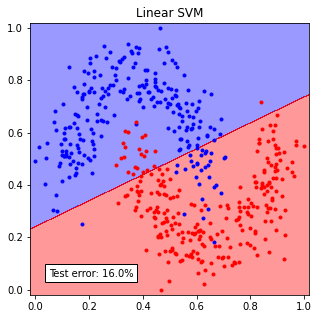

In [16]:
# plot the last classifier
plt.figure(figsize=(5,5))
plt.title(clf_name)
plot_decision_regions(xtr, ytr, clf)
plot_dataset(xtr, ytr)
plt.text(0.05, 0.05, "Test error: {:.1%}".format(error), 
        bbox=dict(facecolor='white'))
plt.show()

Now, let's code this procedure as a function `run`

In [17]:
def run(x, y, splitter, scaler, clf):
    """Take input data (x,y), split it (n times), scale it, 
    learn classifier on training data, and evaluate the mean test error.
    """
    acc = np.zeros(shape=(splitter.get_n_splits(),))

    for i, (tr_idx, ts_idx) in enumerate(splitter.split(x, y)):
        xtr = x[tr_idx, :]
        ytr = y[tr_idx]
        xts = x[ts_idx, :]
        yts = y[ts_idx]

        xtr = scaler.fit_transform(xtr)
        xts = scaler.transform(xts)

        clf.fit(xtr, ytr)
        ypred = clf.predict(xts)
        acc[i] = (ypred == yts).mean()    
    return acc


# sample data
x, y = make_moons(n_samples=1000, noise=0.2)

splitter = ShuffleSplit(n_splits=10, random_state=0, train_size=0.5)

scaler = MinMaxScaler()
clf = svm.SVC(kernel='linear', C=1)      
acc = run(x, y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}".format(acc.mean(), 2*acc.std()))
print("Mean test error: {:.1%} +/- {:.1%}".format(1-acc.mean(), 2*acc.std()))


Mean test accuracy: 86.0% +/- 1.8%
Mean test error: 14.0% +/- 1.8%


Let's test it on the MNIST digit data.

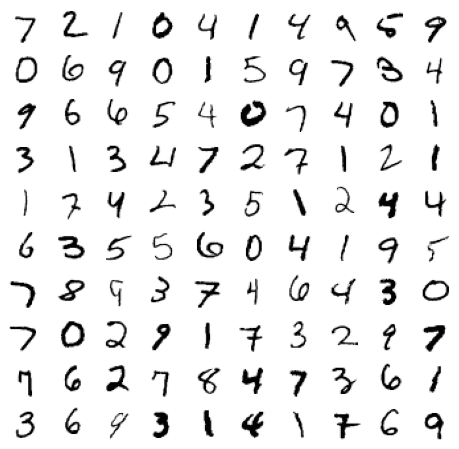

Mean test accuracy: 83.5% +/- 4.3%



In [18]:
x, y = load_mnist(n_samples=500)
plt.figure(figsize=(8,8))
plot_digits(x,y)
plt.show()

clf = svm.SVC(kernel='linear')

acc = run(x, y, splitter, scaler, clf)
print("Mean test accuracy: {:.1%} +/- {:.1%}\n".format(acc.mean(), 2*acc.std()))

## Exercise 2 - Hyperparameter Estimation

In [19]:
from sklearn.model_selection import GridSearchCV

# let's go back to the two-moon dataset
x, y = make_moons(n_samples=1000, noise=0.2)

clf = GridSearchCV(estimator=svm.SVC(kernel='linear'), 
                   param_grid={'C': [0.01, 0.1, 1, 10, 100]})

acc = run(x, y, splitter, scaler, clf)

print("Hyperparameter estimation (5-fold xval)")
print("    - Best parameters set found on development set:", clf.best_params_)
print("    - Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("Mean test accuracy: {:.1%} +/- {:.1%}\n".format(acc.mean(), 2*acc.std()))

Hyperparameter estimation (5-fold xval)
    - Best parameters set found on development set: {'C': 10}
    - Grid scores on development set:
        0.512 (+/-0.008) for {'C': 0.01}
        0.850 (+/-0.042) for {'C': 0.1}
        0.862 (+/-0.029) for {'C': 1}
        0.872 (+/-0.034) for {'C': 10}
        0.866 (+/-0.037) for {'C': 100}
Mean test accuracy: 86.1% +/- 2.0%



Let's use MNIST

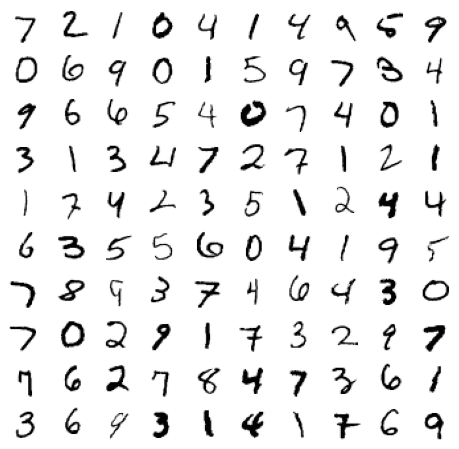

In [0]:
from sklearn.model_selection import GridSearchCV

x, y = load_mnist(n_samples=500)
plt.figure(figsize=(8,8))
plot_digits(x,y)
plt.show()

clf = GridSearchCV(estimator=svm.SVC(kernel='linear'), 
                   param_grid={'C': [0.01, 0.1, 1, 10, 100]})

acc = run(x, y, splitter, scaler, clf)

print("Hyperparameter estimation (5-fold xval)")
print("    - Best parameters set found on development set:", clf.best_params_)
print("    - Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("        %0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print("Mean test accuracy: {:.1%} +/- {:.1%}\n".format(acc.mean(), 2*acc.std()))